In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data From the PI's after Two Weeks
Here we have pulled the scan data from each of the PI's after two weeks of scans. Our plan is to attempt to find common patterns and get closer to indoor localization.

In [2]:
"""
Read in the data. and save to a global dictionary My folder structure looks something like this:
scans/
  pi1/
    [PI1 SCAN LOG FILES HERE]
  pi2/
    [PI2 SCAN LOG FILES HERE]
  pi3/
    [PI3 SCAN LOG FILES HERE]
  pi4/
    [PI4 SCAN LOG FILES HERE]
  M3 Project - Week One Scan Analysis.ipynb
  
"""

# Set up the global dictionary. This will hold ALL of the scans, regardless
# of PI or MAC address.
MAC_DATA = {}

"""
The structue of the data will look something like this:

{
    addr1: [
        (time, rssi, pi),
        (time, rssi, pi),
        (time, rssi, pi),
    ],
    addr2: [
        (time, rssi, pi),
        ...
    ],
    ...
}
"""

import os

dirs = ['pi1', 'pi2', 'pi3', 'pi4']
base_dir = 'M3-project/scripts/downloads/24 Apr 2019/'
for pi in dirs:
    for filename in os.listdir(base_dir + pi):
        # This is the full filename as represented from the current directory.
        file_path = base_dir + pi + '/' + filename
        
        with open(file_path, errors='surrogateescape') as f:
            # Loop over each scan and add it to the dictionary.
            for row in f:
                vals = row.split('\t')
                num_vals = len(vals)
                if num_vals > 4 or num_vals < 3:
                    continue
                elif num_vals == 4:
                    time, mac, rssi, ownership = vals
                elif num_vals == 3:
                    time, mac, rssi = vals
                if mac not in MAC_DATA:
                    MAC_DATA[mac] = []
                MAC_DATA[mac].append((time, rssi, pi))

### Filtering Out Insignificant Devices
Here we want to find out how many times a device should show up before we consider it statistically significant. To accomplish this we will create a mapping between each mac address and how many times it shows up. This data is stored separately for each pi, so we can also see if there are any major differences.

In [24]:
import pandas as pd

In [27]:
"""
Data structure something like the following:

pi_data = {
    pi1: [devices_seen_less_than_1_times, devices_seen_less_than_2_times, ...],
    pi2: [...],
    ...
}

mac_times = {
    addr1: times_seen,
    addr2: times_seen,
    ...
}
"""

pi_data = {}
for pi in dirs:
    pi_data[pi] = []
    mac_times = {}
    # Creates a mapping from mac_addresses to the amount of times seen on a given pi.
    for mac in MAC_DATA:
        for scan in MAC_DATA[mac]:
            if scan[2] == pi:
                mac_times[mac] = mac_times.get(mac, 0) + 1

    # Check if a mac address has been seen by a given pi less than n times (where n is from 1-20)
    for n in range(1, 20):
        total_less_than_n = 0
        for mac in mac_times:
            if mac_times[mac] < n:
                total_less_than_n += 1

        remaining = len(mac_times) - total_less_than_n
        pi_data[pi].append(remaining)

In [30]:
pd.DataFrame(pi_data, index=np.arange(1, 20))

,pi1,pi2,pi3,pi4
1,260298,340494,375375,297076
2,141243,179349,188032,147156
3,43641,50434,59400,47182
4,32914,37542,39017,34867
5,27200,31051,28306,28682
6,24789,28112,24536,25722
7,22612,25756,21784,23258
8,21333,24038,19971,21617
9,20173,22602,18629,20176
10,19126,21293,17590,18970


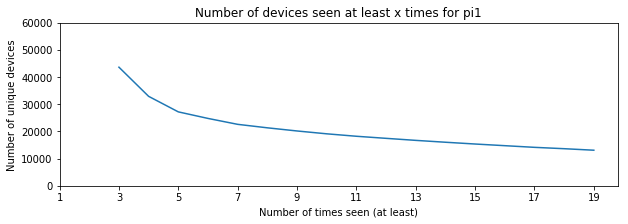

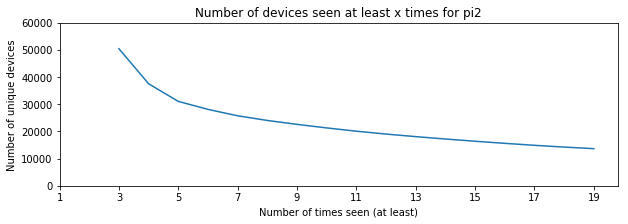

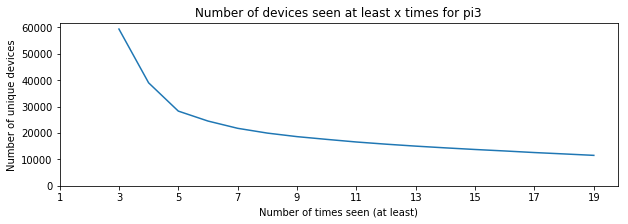

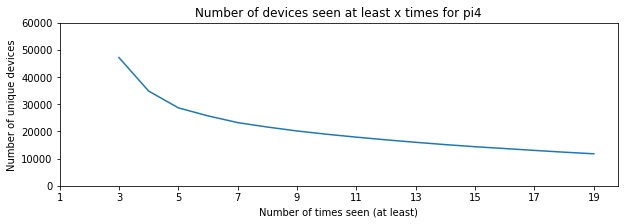

In [138]:
# Plot these values in a nice graph (with n < 2 cut off so more detail can be shown)
for pi in dirs:
    plt.figure(pi[-1], figsize=(10,3))
    plt.plot(np.arange(2, 19)+1, pi_data[pi][2:])
    plt.title("Number of devices seen at least x times for {}".format(pi))
    plt.xticks(np.arange(1, 20, 2))
    plt.yticks(np.arange(0, 60001, 10000))
    plt.xlabel("Number of times seen (at least)")
    plt.ylabel("Number of unique devices")
    plt.show()

In [36]:
import datetime
def convert_to_unix(date_str, resolution_in_secs=600, start_date='2019-02-27T00:00:00.000000', tz_diff_hours=-5):
    """This function converts the time in the log files into an integer number, 
       representing the number of 'blocks' of size `resolution_in_secs` since the 
       `start_date` variable.
       
       If the time is in another timezone, we can specify the difference to our
       preferred timezone with tz_diff_hours (how many hours we have to add to the
       timezone of the data to get to the desired timezone).
    """

    format_str = '%Y-%m-%dT%H:%M:%S.%f'
    start_date = datetime.datetime.strptime(start_date, format_str)
    try:
        scan_date = datetime.datetime.strptime(date_str, format_str)
    except ValueError as err:
        print("{} is an invalid date!".format(date_str))
        return -1
    
    tz_diff_block = (tz_diff_hours * 3600) // resolution_in_secs
    return int((scan_date-start_date).total_seconds()) // resolution_in_secs + tz_diff_block

### Graphing devices over time
Now that we know how many devices show up at least n times, we can pick a value for n and graph how many devices show up at least n times during a specific interval. For this we picked n=5, as we felt it wouldn't create too many false negatives (devices that we say aren't trackable but are in fact student / faculty mobile devices), however futher statistical analysis should probably be used to find a more accurate number for n.

In [37]:
"""
Create basically the same things as MAC_DATA except for each PI. This will help in future calculations.

Data structure:

PI_SCANS = {
    pi1: {
        addr1: [
            (time, rssi, pi),
            (time, rssi, pi),
            ...
        ],
        addr2: [
            ...
        ],
        ...
    },
    pi2: {
        ...
    },
    ...
}
"""

PI_SCANS = {pi: {} for pi in dirs}
for mac in MAC_DATA:
    # For each PI, store each scan that it picked up in a separate mac->scan map
    for scan in MAC_DATA[mac]:
        for pi in dirs:
            if scan[2] == pi:
                if mac not in PI_SCANS[pi]:
                    PI_SCANS[pi][mac] = []
                PI_SCANS[pi][mac].append(scan)

In [38]:
# Save all mac addrs that show up more than n times. Here we have n as 5. This will speed up future calculations.
n = 5
good_macs = {pi: {} for pi in dirs}
for pi in dirs:
    scans = PI_SCANS[pi]
    for mac in scans:
        if len(scans[mac]) > n:
            good_macs[pi][mac] = scans[mac]

In [39]:
# for each pi, save how many unique mac addresses have been seen in a 10 second interval.
pi_time_data = {}
for pi in dirs:
    macs = good_macs[pi]
    time_data = {} # time block -> num
    for mac in macs:
        scans = good_macs[pi][mac]
        times = set()
        for scan in scans:
            converted_time = convert_to_unix(scan[0])
            if converted_time != -1:
                times.add(converted_time)
        for t in times:
            time_data[t] = time_data.get(t, 0) + 1
            
    pi_time_data[pi] = time_data

2019-03-14T22:39:44 is an invalid date!
2019-02-28T17:24:45 is an invalid date!
2019-03-11T17:22:31 is an invalid date!
2019-03-07T21:55:18 is an invalid date!
2019-03-16T12:10:52 is an invalid date!
2019-03-02T20:04:39 is an invalid date!
2019-03-14T06:45:42 is an invalid date!
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

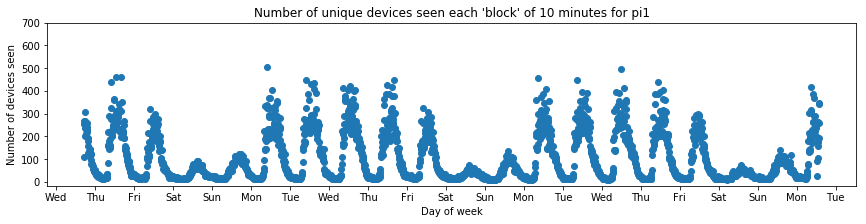

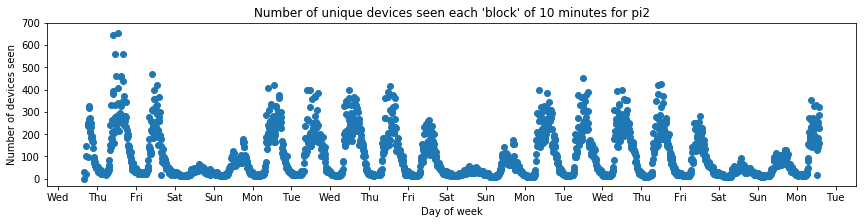

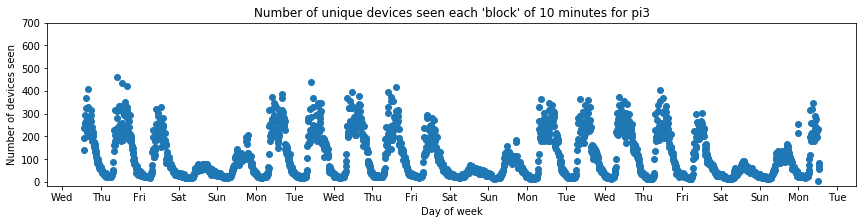

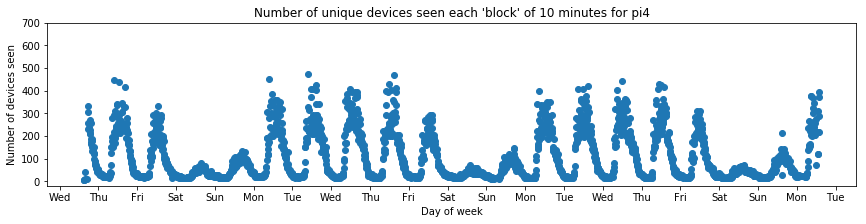

In [48]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
start_day = 2 # Wednesday, the 27th of Feb.

for pi in dirs:
    plt.figure(pi[-1], figsize=(14.5,3))
    x = [val for val in sorted(pi_time_data[pi].keys())]
    y = [pi_time_data[pi][t] for t in x]
    plt.scatter(x, y)
    plt.title("Number of unique devices seen each 'block' of 10 minutes for {}".format(pi))
    plt.xticks(np.arange(0, 2881, 144), [days[(start_day+i)%len(days)] for i in range(21)])
    plt.yticks(np.arange(0, 701, 100))
    plt.xlabel("Day of week")
    plt.ylabel("Number of devices seen")
    plt.show()

### Day-by-day graphs
The following graphs are designed to be breakdowns of the previous graphs one day at a time, however there seems to be some error where the domain of each graph is incorrect. We will try to send an updated version once this is fixed. 

In [49]:
# Export data to save and to make it in an easier to use format.
with open("block_data.csv", 'w') as f:
    f.write("block,pi1,pi2,pi3,pi4\n")
    all_blocks = set()
    for pi in dirs:
        for block in pi_time_data[pi].keys():
            all_blocks.add(block)
    for time_block in sorted(all_blocks):
        p1_val = pi_time_data["pi1"].get(time_block, 0)
        p2_val = pi_time_data["pi2"].get(time_block, 0)
        p3_val = pi_time_data["pi3"].get(time_block, 0)
        p4_val = pi_time_data["pi4"].get(time_block, 0)
        f.write("{},{},{},{},{}\n".format(time_block, p1_val, p2_val, p3_val, p4_val))

In [50]:
# Load the relevant data.
block_data = {}
with open("block_data.csv") as f:
    blocks = f.readlines()[1:]
    for block_row in blocks:
        block, pi1, pi2, pi3, pi4 = block_row.split(',')
        block_data[int(block)] = (int(pi1), int(pi2), int(pi3), int(pi4[:-1]))

sorted_blocks = sorted(block_data.keys())

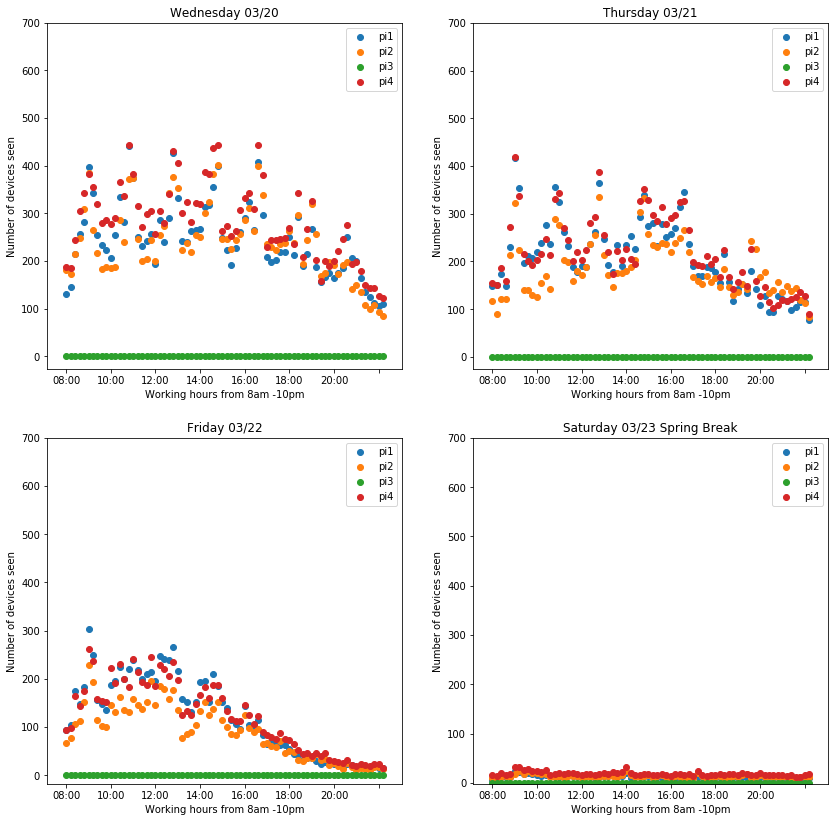

In [152]:
import datetime
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
offset_set = 21 # March 18th.

day_in_blocks = 12 * 60 // 10 # 12 working hr/day (8:00am-8:00pm) * 60 min/hr / 10 min/block -> block/day change the date

start_day = offset_set * (day_in_blocks*2)

f, plots = plt.subplots(2, 2, figsize=(14, 14)) # 10 rows/2 box
for day_offset in range(4): # range 10 therefore 10 boxes
    day_index = (offset_set + day_offset) % 7 #(2+0)%7
    row, col = day_offset % 2, day_offset // 2 #Box location
    curr_day = start_day+ (day_in_blocks*2) * day_offset + 48 #Title (6*8 6 * starting at 8)
    next_day = start_day+ (day_in_blocks*2) * (day_offset + 1) -24 #Next day (6*4 -4 from 12 am)
    
    # Plot each PI
    for pi in range(4):
        x = [block for block in sorted_blocks if block >= curr_day and block < next_day]
        y = [block_data[block][pi] for block in x]
        plots[col][row].scatter(x, y, label="pi{}".format(pi+1))
    
    d = day_offset + offset_set
    d1 = datetime.datetime(year=2019, month=2, day=27)
    delta = datetime.timedelta(days=d) 

    plots[col][row].set_title((d1 + delta).strftime("%A %m/%d"))
    
    if (plots[col][row].get_title()=="Saturday 03/23"):
        plots[col][row].set_title((d1 + delta).strftime("%A %m/%d Spring Break")) 
        
    plots[col][row].yaxis.set_ticks(np.arange(0, 701, 100))
    plots[col][row].xaxis.set_ticks(np.arange(curr_day, next_day, day_in_blocks // 7)) #ticks(np.arange(min(x), max(x)+1, 1.0))
    plots[col][row].xaxis.set_ticklabels(["{:02}:00".format(i*2+8) for i in range(7)])
    plots[col][row].set_xlabel("Working hours from 8am -10pm")
    plots[col][row].set_ylabel("Number of devices seen")
    plots[col][row].legend()
plt.show()

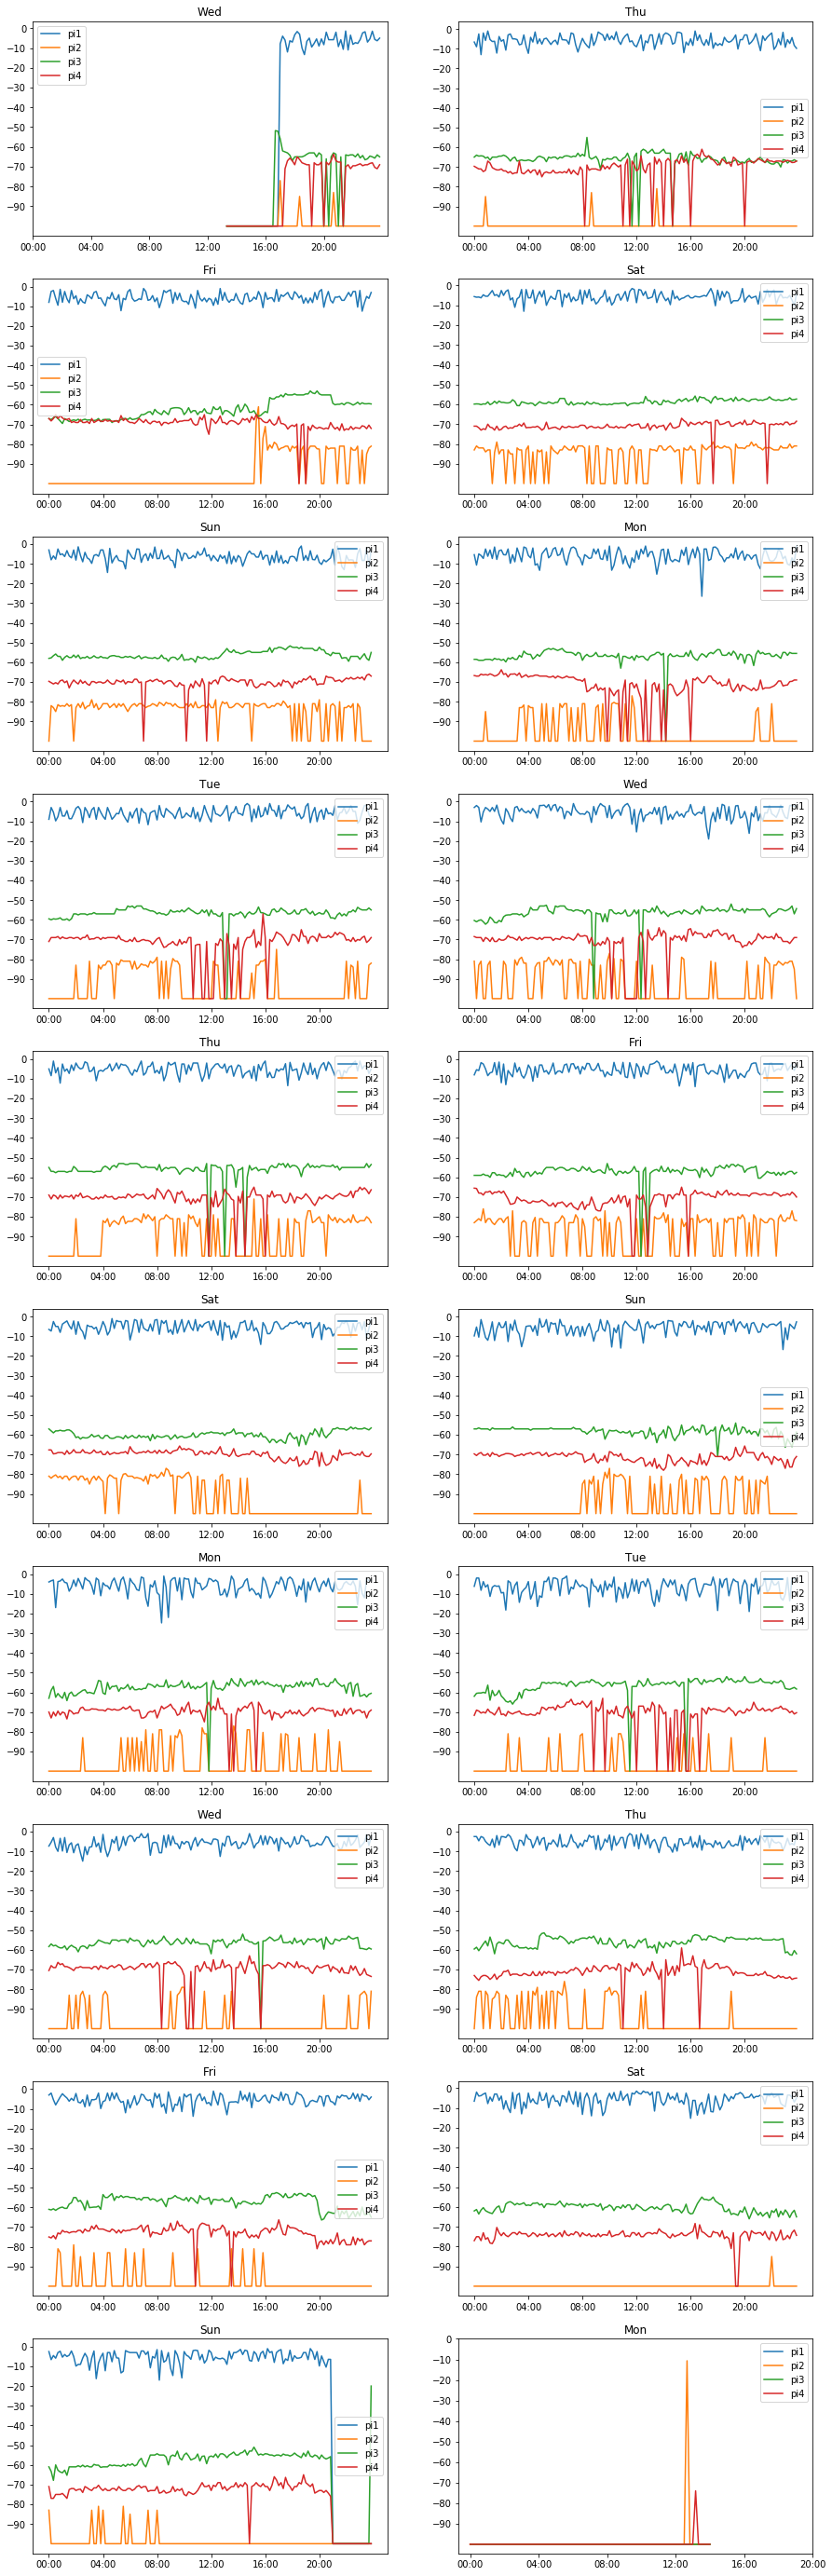

In [154]:
jarvis_blocks = {}
pi_macs = [
    "b8:27:eb:43:43:88",
    "b8:27:eb:62:a6:92",
    "b8:27:eb:73:ef:34",
    "b8:27:eb:e9:09:83"
]
for pi in dirs:
    for scan in good_macs[pi][pi_macs[0]]:
        block = convert_to_unix(scan[0])
        strength = int(scan[1])
        if block not in jarvis_blocks:
            jarvis_blocks[block] = {}
        if pi not in jarvis_blocks[block]:
            jarvis_blocks[block][pi] = []
        jarvis_blocks[block][pi].append(strength)

def avg(arr):
    if len(arr) == 0: return -100
    return sum(arr) / len(arr)

day_in_blocks = 144
f, plots = plt.subplots(10, 2, figsize=(15, 50))
for day_offset in range(20):
    day_index = (start_day + day_offset) % 7
    row, col = day_offset % 2, day_offset // 2
    curr_day = day_in_blocks * day_offset
    next_day = day_in_blocks * (day_offset + 1)
    
    # Plot each PI
    x = [block for block in sorted_blocks if block >= curr_day and block < next_day]
    for pi in dirs:
        y = [avg(jarvis_blocks.get(block, {}).get(pi, [])) for block in x]
        plots[col][row].plot(x, y, label=pi)
        
    plots[col][row].set_title(days[day_index])
    plots[col][row].yaxis.set_ticks(np.arange(0, -100, -10))
    plots[col][row].xaxis.set_ticks(np.arange(day_in_blocks * day_offset, day_in_blocks * (day_offset + 1), day_in_blocks // 6))
    plots[col][row].xaxis.set_ticklabels(["{:02}:00".format(i * 4) for i in range(6)])
    plots[col][row].legend()
plt.show()

In [188]:

def data_style(data):
    return ['background-color: yellow' if type(v) != type('str') and v > -10 else '' for v in data]

pi_macs = {
    "pi1": "b8:27:eb:43:43:88",
    "pi2": "b8:27:eb:73:ef:34",
    "pi3": "b8:27:eb:62:a6:92",
    "pi4": "b8:27:eb:e9:09:83"
}
headers = ["Connection", "Mean", "Max", "Min", "Std Dev"]
rows = []

for pi in dirs:
    for dev in pi_macs:
        pi_mac = pi_macs[dev]
        rssis = []
        for scan in good_macs[pi][pi_mac]:
            block = convert_to_unix(scan[0])
            rssi = int(scan[1])
            rssis.append(rssi)
        np_rssis = np.array(rssis)
        vals = ["{} -> {}".format(pi, dev) if pi != dev else pi,
                "{:.2f}".format(np.mean(np_rssis)),
                "{:.2f}".format(np.max(np_rssis)),
                "{:.2f}".format(np.min(np_rssis)),
                "{:.2f}".format(np.std(np_rssis))]
        rows.append(vals)
        
df = pd.DataFrame(np.array(rows)[:,1:], index=[row[0] for row in rows], columns=headers[1:])
df.style.apply(data_style)


,Mean,Max,Min,Std Dev
pi1,-6.17,-1.00,-87.00,8.07
pi1 -> pi2,-74.38,-61.00,-81.00,4.34
pi1 -> pi3,-67.18,-29.00,-79.00,5.13
pi1 -> pi4,-75.42,-19.00,-85.00,5.42
pi2 -> pi1,-81.37,-9.00,-87.00,4.87
pi2,-12.78,-1.00,-85.00,11.19
pi2 -> pi3,-70.35,-17.00,-85.00,4.13
pi2 -> pi4,-59.09,-25.00,-83.00,3.83
pi3 -> pi1,-58.34,-19.00,-83.00,4.50
pi3 -> pi2,-73.67,-31.00,-87.00,3.29


## Conclusions
As you can see from the graphs above, each device peaks each day, with much smaller peaks on the weekends. This is to be expected as most students are only in Benton to take classes, with a few faculty and students coming in on the weekends to work on homework / projects.

Once we find out a number for n, our plan is to have the PI's keep track of how many times we've seen each MAC address, and only save / send data to the server if that number is over n. 